***
***
# <div align="center"><font color='BLUE'><b>AREEBA FATAH </b></font></div>
***
# <div align="center"><font color='indigo'><b>GENERATIVE AI</b></font></div>
***
# <div align="center"><font color='indigo'><b>21I-0349</b></font></div>
***
# <div align="center"><font color='BLUE'><b>ASSIGNMENT 1</b></font></div>
***
# <div align="center"><font color='BLUE'><b>Task 2</b></font></div>
***
***

# TASK EXPLANATION
1)- Approach one encoding is done on the basis of max occurences after cleaning which didn't give any good results <br>
2)- Approach two directly encode the words as numbers , relatively fast and gives good results<br>
3)- GridSearch for better parameters<br>
4)- Rnn comparison

# IMPORTING LIBRARIES

1- Here we have used numpy and pandas which are basic libraries for any python project. <br>
2- NLTK is used for removing stopwords and stuff.<br>
3- re is used for getting rid of punctuations,roman numbers.<br>
4- collections for creating vocabulary.<br>
5- torch for lstm as tensorflow had some issues with my flask and was not resolved.<br>
6- matplotlib for visualization

In [1]:
import re
import nltk
import torch
import string
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.tokenize import word_tokenize
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# DATA CLEANING AND PREPROCESSING
1)- Reading the lines from txt as csv is structured so it takes more time and theres is no difference. <br>
2)- Converted text to lower case and removed highly occuring words like act,scene and roman numbers.<br>
3)- Used MAX occurances for conversion to integers ( better than one hot encoding which causes memory issues here) i want to create more context with all of the data . this approach is not the best , i have added a few more approaches ahead.<br>
4)- creating a sequence of inputs and their targets with simple numpy.<br>

In [3]:
''' 1)- A function for cleaning shakespeares' lines i.e. 
            ~ converting to lower_case,
            ~ removing the word act,scene, (reason: frequent repetition bad performance)
            ~ punctuations, 
            ~ roman_numbers
            ~ extra spaces 
'''
def Shakespeare_text_cleaner_with_stopwords_removal(shakespeare_lines):
    shakespeare_lines=shakespeare_lines.lower()
    shakespeare_lines=re.sub(r'\b(scene|act)\b',' ',shakespeare_lines)
    shakespeare_lines=re.sub(r'\b([ivxlc]{1,4})\b',' ',shakespeare_lines,flags=re.IGNORECASE)  
    shakespeare_lines=re.sub(r'[^a-z\s]',' ',shakespeare_lines)  
    shakespeare_lines = re.sub(r'\s+',' ',shakespeare_lines).strip()  
    
    stop_words_english=set(stopwords.words('english'))
    shakespeare_words=word_tokenize(shakespeare_lines)
    shakespeare_words=[word for word in shakespeare_words if word not in stop_words_english]
    return shakespeare_words
    

''' 2)- A function for reading lines from alllines.txt, reason: it is easy to read them csv which takes a lot of time and memory
            ~ This function will call the previous one and return the cleaned words.
'''
def Shakespeares_lines_reader(shakespeare_path):
    with open(shakespeare_path,'r',encoding='utf-8') as shakespeare_reader:
        playlines_unprocessed=shakespeare_reader.read()
    return Shakespeare_text_cleaner_with_stopwords_removal(playlines_unprocessed)

    
''' 3 - A function to define the shakepeare's vocabulary i.e counting the word occurences with words
            A dictionary to store the words with their occurences along with saving it in pickle file 
            as my system is not strong enough to process this file
'''
def Shakespeare_vocab_generator(shakespeare_words):
    word_frequencies=defaultdict(int)
    for one_shakespeares_word in shakespeare_words:
        word_frequencies[one_shakespeares_word]+=1
    shakespeare_vocab={one_shakespeares_word: index for index,one_shakespeares_word in enumerate(word_frequencies.keys())}
    
    with open('shakespeare_vocab.pkl','wb') as shakespeare_vocab_writer:
        pickle.dump(shakespeare_vocab,shakespeare_vocab_writer)
    return shakespeare_vocab


''' 4- A function to create overlapping sequences of shakespeare vocab
        integer = word occurences
'''
def shakespeare_sequence_creation(shakepeare_words,shakespeare_vocab,sequence_length=5):
    shakespeare_integers=[shakespeare_vocab[shakepeare_word] for shakepeare_word in shakepeare_words]
    shakespeare_sequences=[]
    shakespeare_targets=[]
    for i in range(len(shakespeare_integers)-sequence_length):
        shakespeare_sequences.append(shakespeare_integers[i:i+sequence_length])
        shakespeare_targets.append(shakespeare_integers[i+sequence_length])
    shakespeare_sequences=np.array(shakespeare_sequences)
    shakespeare_targets=np.array(shakespeare_targets)
    return shakespeare_sequences,shakespeare_targets

 1)- A function for cleaning shakespeares' lines i.e. 
            ~ converting to lower_case,
            ~ removing the word act,scene, (reason: frequent repetition bad performance)
            ~ punctuations, 
            ~ roman_numbers
            ~ extra spaces 
<br>
 2)- A function for reading lines from alllines.txt, reason: it is easy to read them csv which takes a lot of time and memory
            ~ This function will call the previous one and return the cleaned words.
<br>
3 - A function to define the shakepeare's vocabulary i.e counting the word occurences with words
            A dictionary to store the words with their occurences along with saving it in pickle file 
            as my system is not strong enough to process this file
<br>
A function to create overlapping sequences of shakespeare vocab
        integer = word occurences


In [4]:
''' CALLING THE ABOVE FUNCTIONS TO CHECK THEIR WORKING
'''
shakespeare_plays_path='/kaggle/input/shakespeare-plays/alllines.txt' 
shakepeare_data=Shakespeares_lines_reader(shakespeare_plays_path)
shakespeare_vocab=Shakespeare_vocab_generator(shakepeare_data)
shakepeare_sequences,shakespeare_targets=shakespeare_sequence_creation(shakepeare_data,shakespeare_vocab,sequence_length=5)

# TRAINING THE MODEL

### TRAINING WITH MAX OCCURANCES INTEGER TYPE ENCODING

In [5]:
''' PREPARING THE DATA FOR PYTORCH SINCE MY TENSORFLOW HAS ISSUES WITH MODEL SAVING AND RETRIEVING 
    IN FLASK
'''
shakepeare_sequences_t=torch.tensor(shakepeare_sequences,dtype=torch.long)
shakepeare_targets_t=torch.tensor(shakespeare_targets,dtype=torch.long)
shakespeare_dataset=TensorDataset(shakepeare_sequences_t,shakepeare_targets_t)
shakespeare_dataloader=DataLoader(shakespeare_dataset,batch_size=32,shuffle=True)

### SHAKESPEARE'S LSTM

In [8]:
''' 
 here i have used a simple lstm with one input one lstm and one linear layer for output
     as output is one word
'''
class Shakespeare_LSTM(nn.Module):
    def __init__(self,vocab_length,embedding_dimensions,hidden_dimensions):
        super(Shakespeare_LSTM, self).__init__()
        self.shakespeare_embedding=nn.Embedding(vocab_length,embedding_dimensions)
        self.shakespeare_lstm=nn.LSTM(embedding_dimensions,hidden_dimensions,batch_first=True)
        self.shakespeare_linear=nn.Linear(hidden_dimensions,vocab_length)
        
    def forward(self,words):
        words=self.shakespeare_embedding(words)
        words,_=self.shakespeare_lstm(words)
        words=self.shakespeare_linear(words[:,-1,:]) 
        return words

Here created a basic lstm like which has many to one type architecture.

In [45]:
''' TRAINING THE MODEL
'''
shakespeares_model=Shakespeare_LSTM(len(shakespeare_vocab),64,128)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(shakespeares_model.parameters())
shakespeare_losses=[]
shakespeare_acc=[]


for epoch in range(10):
    Total_loss=0
    Correct_preds=0
    Total_preds=0
    
    for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
        optimizer.zero_grad()
        output=shakespeares_model(shakespeare_seq)
        loss=criterion(output,shakespeare_target)
        loss.backward()
        optimizer.step()
        Total_loss += loss.item() 
        _,pred=torch.max(output,1)  
        Correct_preds+=(pred==shakespeare_target).sum().item()  
        Total_preds+=shakespeare_target.size(0) 
    avg_loss=Total_loss/len(shakespeare_dataloader)  
    accuracy=Correct_preds /Total_preds  
    shakespeare_losses.append(avg_loss) 
    shakespeare_acc.append(accuracy)

    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

torch.save(shakespeares_model.state_dict(),'lstm_shakespeare_model.pt')

Epoch: 1, Loss: 8.0803, Accuracy: 0.0221
Epoch: 2, Loss: 7.6555, Accuracy: 0.0332
Epoch: 3, Loss: 7.3893, Accuracy: 0.0396
Epoch: 4, Loss: 7.1615, Accuracy: 0.0453
Epoch: 5, Loss: 6.9557, Accuracy: 0.0509
Epoch: 6, Loss: 6.7680, Accuracy: 0.0567
Epoch: 7, Loss: 6.5994, Accuracy: 0.0630
Epoch: 8, Loss: 6.4446, Accuracy: 0.0693
Epoch: 9, Loss: 6.3050, Accuracy: 0.0759
Epoch: 10, Loss: 6.1720, Accuracy: 0.0833


Up till 10 epochs it took one hour and the accuracy is far from good i.e. 8%.


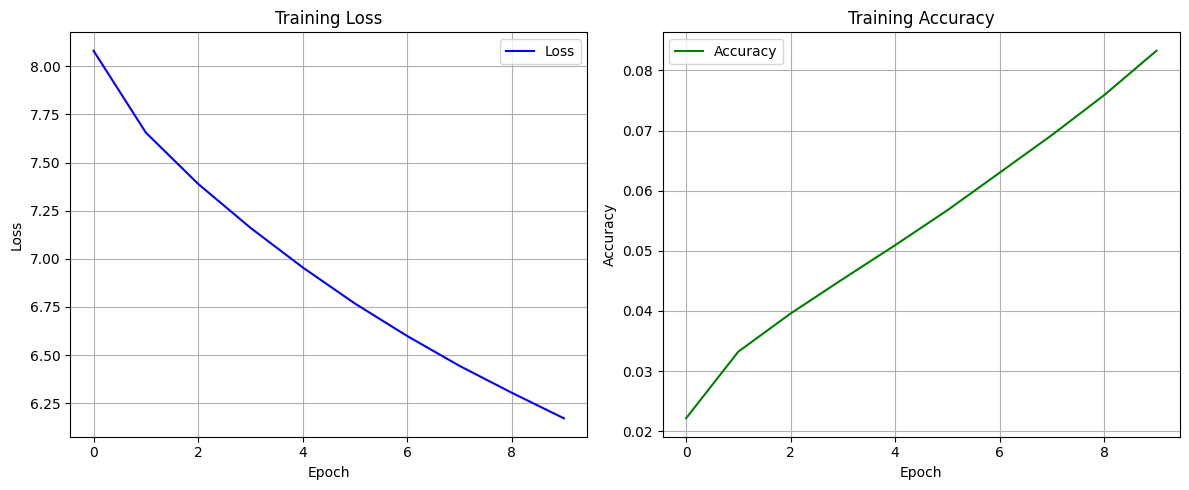

In [46]:
''' Plotting the results '''
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(shakespeare_losses, label='Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(shakespeare_acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## APPROACH 2: TEXT TO INT DIRECTLY (FASTER APPROACH)
It means that word-index mappings are used.

In [9]:
# reference to : https://www.kaggle.com/code/apoorvchaudhary/text-generation-nlp-lstm
'''
Here slight adjustment is made to these two functions, that is Non Ascii special characters to
english as done above
'''
def Shakespeare_text_cleaner_with_stopwords_removal(shakespeare_lines):
    shakespeare_lines="".join(char for char in shakespeare_lines if char not in string.punctuation).lower()
    shakespeare_lines=shakespeare_lines.encode("utf8").decode("ascii",'ignore')
    shakespeare_lines=re.sub(r'\b(scene|act)\b', ' ', shakespeare_lines)
    shakespeare_lines=re.sub(r'\b([ivxlc]{1,4})\b', ' ',shakespeare_lines, flags=re.IGNORECASE)
    shakespeare_lines=re.sub(r'\s+', ' ', shakespeare_lines).strip()
    stop_words_english=set(stopwords.words('english'))
    shakespeare_words=word_tokenize(shakespeare_lines)
    shakespeare_words=[word for word in shakespeare_words if word not in stop_words_english]
    return shakespeare_words

''' Same as above
'''
def Shakespeares_lines_reader(shakespeare_path):
    with open(shakespeare_path,'r',encoding='utf-8') as shakespeare_reader:
        playlines_unprocessed = shakespeare_reader.readlines()
    return [Shakespeare_text_cleaner_with_stopwords_removal(line) for line in playlines_unprocessed]


''' 5)- this function converts unique words directly to integers '''
def Preparing_Shakespeare_data(shakespeare_corpus):
    flattened_corpus=[word for sublist in shakespeare_corpus for word in sublist]
    unique_words=set(flattened_corpus)
    Word_index={word:i+1 for i,word in enumerate(unique_words)}
    Total_words=len(Word_index)+1 
    shakespeare_sequences=[[Word_index[word] for word in sublist] for sublist in shakespeare_corpus]
    return shakespeare_sequences,Word_index,Total_words


''' 6) slight modification of the function above
    here we directly get sequences for the words
  '''
def shakespeare_sequences(shakespeare_seq,seq_length=5):
    S_sequences=[]
    S_targets=[]
    for seq in shakespeare_seq:
        for i in range(len(seq)-seq_length):
            S_sequences.append(seq[i:i+seq_length])
            S_targets.append(seq[i+seq_length])
    return np.array(S_sequences),np.array(S_targets)


Epoch: 1, Loss: 8.6992, Accuracy: 0.0155
Epoch: 2, Loss: 7.4504, Accuracy: 0.0257
Epoch: 3, Loss: 6.8026, Accuracy: 0.0406
Epoch: 4, Loss: 5.9863, Accuracy: 0.0672
Epoch: 5, Loss: 5.1487, Accuracy: 0.1346
Epoch: 6, Loss: 4.3415, Accuracy: 0.2561
Epoch: 7, Loss: 3.6036, Accuracy: 0.3933
Epoch: 8, Loss: 2.9403, Accuracy: 0.5099
Epoch: 9, Loss: 2.3828, Accuracy: 0.6129
Epoch: 10, Loss: 1.9168, Accuracy: 0.6971
Epoch: 11, Loss: 1.5392, Accuracy: 0.7712
Epoch: 12, Loss: 1.2234, Accuracy: 0.8298
Epoch: 13, Loss: 0.9615, Accuracy: 0.8778
Epoch: 14, Loss: 0.7502, Accuracy: 0.9117
Epoch: 15, Loss: 0.5796, Accuracy: 0.9432
Epoch: 16, Loss: 0.4432, Accuracy: 0.9650
Epoch: 17, Loss: 0.3299, Accuracy: 0.9804
Epoch: 18, Loss: 0.2467, Accuracy: 0.9882
Epoch: 19, Loss: 0.1857, Accuracy: 0.9923
Epoch: 20, Loss: 0.1388, Accuracy: 0.9950


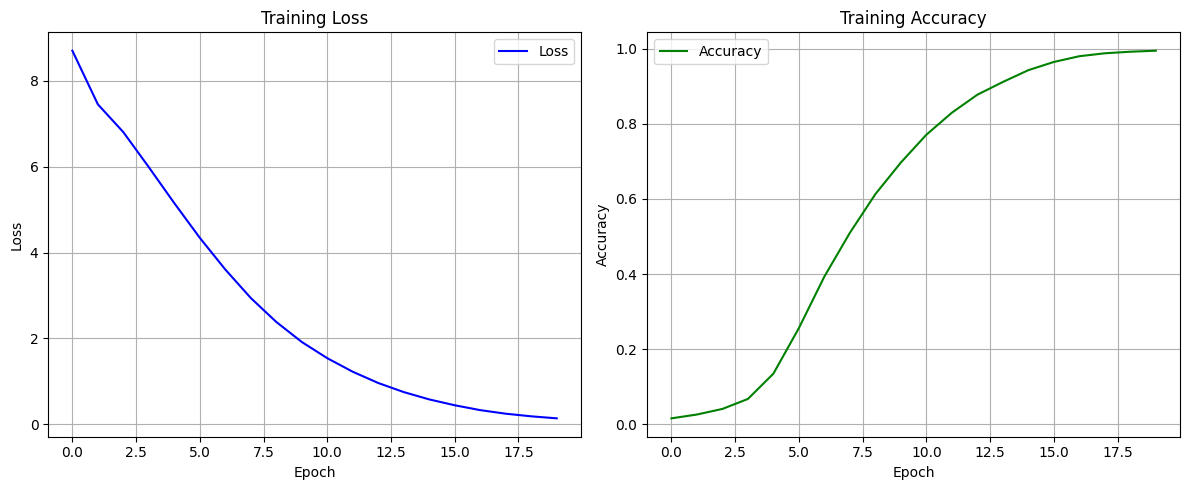

In [20]:
''' Data preparation like above '''
shakespeare_path='/kaggle/input/shakespeare-plays/alllines.txt'
shakespeare_data=Shakespeares_lines_reader(shakespeare_path)
shakespeare_seq,Word_index,Total_words=Preparing_Shakespeare_data(shakespeare_data)
S_sequences,S_targets=shakespeare_sequences(shakespeare_seq)
X_tensor=torch.tensor(S_sequences,dtype=torch.long)
y_tensor=torch.tensor(S_targets,dtype=torch.long)
shakespeare_dataset=TensorDataset(X_tensor,y_tensor)
train_dataset,test_dataset=train_test_split(shakespeare_dataset,test_size=0.2,shuffle=True)
shakespeare_dataloader_train=DataLoader(train_dataset,batch_size=32,shuffle=True)

'''
 A fucntion that incorporates all of the training of shakespaeare dataset
'''
def Shakespeare_training(shakespeare_dataloader):
    Shakespeare_model=Shakespeare_LSTM(Total_words,64,128)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(Shakespeare_model.parameters())
    shakespeare_losses=[]
    shakespeare_acc=[]
    for epoch in range(20):
        Total_loss=0
        Correct_preds=0
        Total_preds=0
        for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
            optimizer.zero_grad()
            output=Shakespeare_model(shakespeare_seq)
            loss=criterion(output,shakespeare_target)
            loss.backward()
            optimizer.step()
            Total_loss+=loss.item()
            _,pred=torch.max(output,1) 
            Correct_preds+=(pred==shakespeare_target).sum().item() 
            Total_preds+=shakespeare_target.size(0)
        avg_loss=Total_loss/len(shakespeare_dataloader)
        accuracy=Correct_preds/Total_preds  
        shakespeare_losses.append(avg_loss) 
        shakespeare_acc.append(accuracy)
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(shakespeare_losses, label='Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(shakespeare_acc, label='Accuracy', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
    torch.save(Shakespeare_model.state_dict(), 'lstm_shakespeare_model.pt')
    return Shakespeare_model
    
Shakespeare_model=Shakespeare_training(shakespeare_dataloader_train)
with open('vocabulary.pkl','wb') as vocab_writer:
    pickle.dump(Word_index,vocab_writer)

## VALIDATION 

Validation Loss: 11.2869, Validation Accuracy: 0.0376


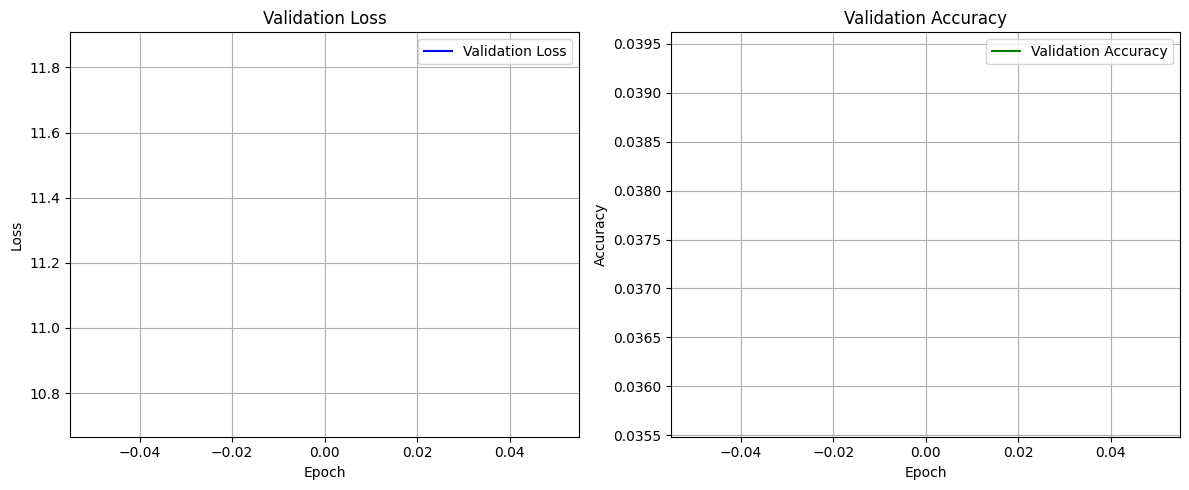

In [22]:
def Shakespeare_validation(shakespeare_dataloader,Shakespeare_model):
    criterion=nn.CrossEntropyLoss()
    shakespeare_losses=[]
    shakespeare_acc=[]
    Shakespeare_model.eval()  
    Total_loss=0    
    Correct_preds=0
    Total_preds=0
    
    with torch.no_grad(): 
        for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
            output=Shakespeare_model(shakespeare_seq)
            loss=criterion(output, shakespeare_target)
            Total_loss+=loss.item()
            _, pred=torch.max(output,1) 
            Correct_preds+=(pred==shakespeare_target).sum().item() 
            Total_preds+=shakespeare_target.size(0)
        
    # Calculating  average loss and accuracy
    avg_loss=Total_loss/len(shakespeare_dataloader)
    accuracy=Correct_preds/Total_preds  
    shakespeare_losses.append(avg_loss) 
    shakespeare_acc.append(accuracy)
    
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
    # Plotting the validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(shakespeare_losses, label='Validation Loss', color='blue')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(shakespeare_acc, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
Shakespeare_validation(DataLoader(test_dataset,batch_size=32,shuffle=True),Shakespeare_model)

this model gives good accuracy with relatively less time i.e 67%.


# GRID SEARCH CV

Although i am doing it down here but the parameters from these will be used above

In [14]:
def Shakespeare_training(Shakespeare_model,shakespeare_dataloader,criterion, optimizer,num_epochs=10):
    for epoch in range(num_epochs):
        Total_loss=0
        Correct_preds=0
        Total_preds=0
        for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
            optimizer.zero_grad()
            output=Shakespeare_model(shakespeare_seq)
            loss=criterion(output,shakespeare_target)
            loss.backward()
            optimizer.step()
            Total_loss+=loss.item()
            _,pred=torch.max(output,1) 
            Correct_preds+=(pred==shakespeare_target).sum().item() 
            Total_preds+=shakespeare_target.size(0)
        avg_loss=Total_loss/len(shakespeare_dataloader)
        accuracy=Correct_preds/Total_preds  
        shakespeare_losses.append(avg_loss) 
        shakespeare_acc.append(accuracy)
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return accuracy

In [17]:
parameters_grid={'embedding_dim':[32,64],'hidden_dim':[64, 128],'num_epochs':[10,20]}
best_accuracy=0
best_params={}
for params in ParameterGrid(parameters_grid):
    print(f"Testing parameters: {params}")
    model=Shakespeare_LSTM(Total_words,params['embedding_dim'],params['hidden_dim'])
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters())
    print(f"Training with embedding_dim={params['embedding_dim']} and hidden_dim={params['hidden_dim']}")
    accuracy=Shakespeare_training(model,shakespeare_dataloader,criterion,optimizer,params['num_epochs'])
    if (accuracy*100)>best_accuracy:
        best_accuracy=accuracy
        best_params=params

print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.4f}")


Testing parameters: {'embedding_dim': 32, 'hidden_dim': 64, 'num_epochs': 10}
Training with embedding_dim=32 and hidden_dim=64
Epoch: 1, Loss: 8.6577, Accuracy: 0.0150
Epoch: 2, Loss: 7.6272, Accuracy: 0.0198
Epoch: 3, Loss: 7.3190, Accuracy: 0.0254
Epoch: 4, Loss: 6.9481, Accuracy: 0.0329
Epoch: 5, Loss: 6.5216, Accuracy: 0.0466
Epoch: 6, Loss: 6.0843, Accuracy: 0.0620
Epoch: 7, Loss: 5.6748, Accuracy: 0.0884
Epoch: 8, Loss: 5.2830, Accuracy: 0.1267
Epoch: 9, Loss: 4.9204, Accuracy: 0.1738
Epoch: 10, Loss: 4.5778, Accuracy: 0.2281
Testing parameters: {'embedding_dim': 32, 'hidden_dim': 64, 'num_epochs': 20}
Training with embedding_dim=32 and hidden_dim=64
Epoch: 1, Loss: 8.6787, Accuracy: 0.0153
Epoch: 2, Loss: 7.6173, Accuracy: 0.0201
Epoch: 3, Loss: 7.3213, Accuracy: 0.0266
Epoch: 4, Loss: 6.9301, Accuracy: 0.0365
Epoch: 5, Loss: 6.5029, Accuracy: 0.0501
Epoch: 6, Loss: 6.0840, Accuracy: 0.0645
Epoch: 7, Loss: 5.6832, Accuracy: 0.0862
Epoch: 8, Loss: 5.3018, Accuracy: 0.1187
Epoch: 

# With RNN


In [25]:
class Shakespeare_RNN(nn.Module):
    def __init__(self,vocab_length,embedding_dimensions,hidden_dimensions):
        super(Shakespeare_RNN, self).__init__()
        self.Shakespeare_embedding=nn.Embedding(vocab_length,embedding_dimensions)
        self.Shakespeare_rnn=nn.RNN(embedding_dimensions,hidden_dimensions,batch_first=True)
        self.Shakespeare_linear=nn.Linear(hidden_dimensions,vocab_length)

    def forward(self, x):
        x=self.Shakespeare_embedding(x)
        x,_=self.Shakespeare_rnn(x)
        x=self.Shakespeare_linear(x[:,-1,:]) 
        return x


Epoch: 1, Loss: 8.6460, Accuracy: 0.0187
Epoch: 2, Loss: 7.2239, Accuracy: 0.0346
Epoch: 3, Loss: 6.5017, Accuracy: 0.0524
Epoch: 4, Loss: 5.6870, Accuracy: 0.0850
Epoch: 5, Loss: 4.8520, Accuracy: 0.1688
Epoch: 6, Loss: 4.0375, Accuracy: 0.3154
Epoch: 7, Loss: 3.2872, Accuracy: 0.4501
Epoch: 8, Loss: 2.6598, Accuracy: 0.5563
Epoch: 9, Loss: 2.1465, Accuracy: 0.6469
Epoch: 10, Loss: 1.7302, Accuracy: 0.7215
Epoch: 11, Loss: 1.3868, Accuracy: 0.7852
Epoch: 12, Loss: 1.1082, Accuracy: 0.8329
Epoch: 13, Loss: 0.8762, Accuracy: 0.8790
Epoch: 14, Loss: 0.6917, Accuracy: 0.9122
Epoch: 15, Loss: 0.5391, Accuracy: 0.9403
Epoch: 16, Loss: 0.4153, Accuracy: 0.9595
Epoch: 17, Loss: 0.3191, Accuracy: 0.9726
Epoch: 18, Loss: 0.2425, Accuracy: 0.9845
Epoch: 19, Loss: 0.1871, Accuracy: 0.9887
Epoch: 20, Loss: 0.1423, Accuracy: 0.9916


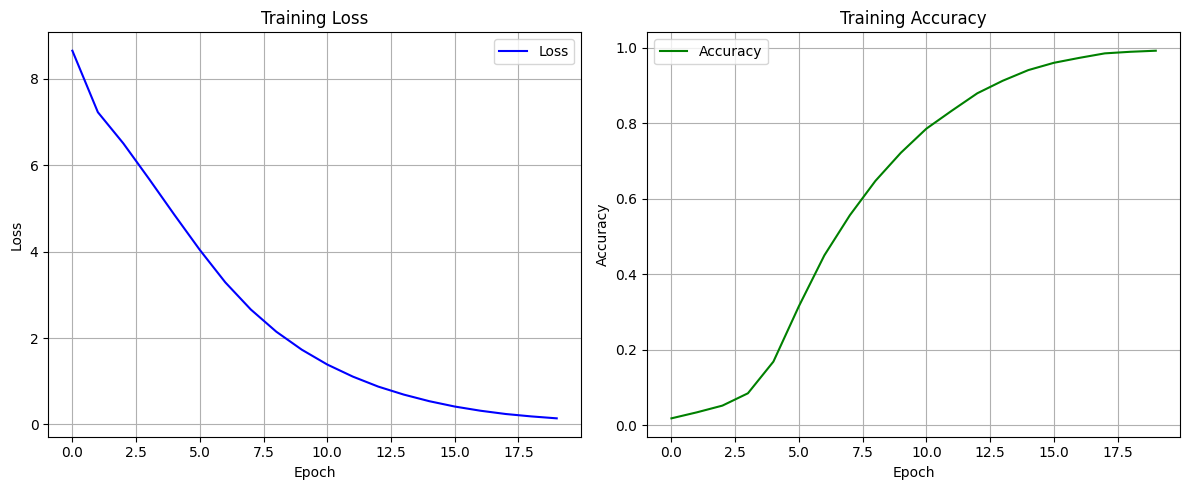

In [27]:
''' Data preparation like above '''
shakespeare_path='/kaggle/input/shakespeare-plays/alllines.txt'
shakespeare_data=Shakespeares_lines_reader(shakespeare_path)
shakespeare_seq,Word_index,Total_words=Preparing_Shakespeare_data(shakespeare_data)
S_sequences,S_targets=shakespeare_sequences(shakespeare_seq)
X_tensor=torch.tensor(S_sequences,dtype=torch.long)
y_tensor=torch.tensor(S_targets,dtype=torch.long)
shakespeare_dataset=TensorDataset(X_tensor,y_tensor)
train_dataset,test_dataset=train_test_split(shakespeare_dataset,test_size=0.2,shuffle=True)
shakespeare_dataloader_train=DataLoader(train_dataset,batch_size=32,shuffle=True)

'''
 A fucntion that incorporates all of the training of shakespaeare dataset
'''
def Shakespeare_training(shakespeare_dataloader):
    Shakespeare_model=Shakespeare_RNN(Total_words,64,128)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(Shakespeare_model.parameters())
    shakespeare_losses=[]
    shakespeare_acc=[]
    for epoch in range(20):
        Total_loss=0
        Correct_preds=0
        Total_preds=0
        for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
            optimizer.zero_grad()
            output=Shakespeare_model(shakespeare_seq)
            loss=criterion(output,shakespeare_target)
            loss.backward()
            optimizer.step()
            Total_loss+=loss.item()
            _,pred=torch.max(output,1) 
            Correct_preds+=(pred==shakespeare_target).sum().item() 
            Total_preds+=shakespeare_target.size(0)
        avg_loss=Total_loss/len(shakespeare_dataloader)
        accuracy=Correct_preds/Total_preds  
        shakespeare_losses.append(avg_loss) 
        shakespeare_acc.append(accuracy)
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(shakespeare_losses, label='Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(shakespeare_acc, label='Accuracy', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
    torch.save(Shakespeare_model.state_dict(), 'lstm_shakespeare_model.pt')
    return Shakespeare_model
    
Shakespeare_model=Shakespeare_training(shakespeare_dataloader_train)

Validation Loss: 11.2932, Validation Accuracy: 0.0341


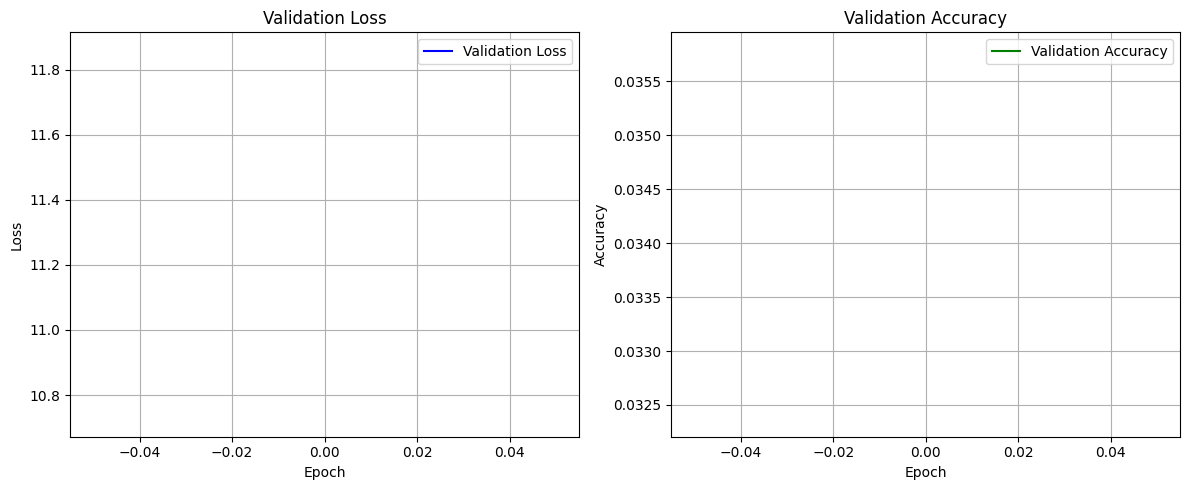

In [28]:
def Shakespeare_validation(shakespeare_dataloader,Shakespeare_model):
    criterion=nn.CrossEntropyLoss()
    shakespeare_losses=[]
    shakespeare_acc=[]
    
    Shakespeare_model.eval()  
    Total_loss=0    
    Correct_preds=0
    Total_preds=0
    
    with torch.no_grad(): 
        for shakespeare_seq,shakespeare_target in shakespeare_dataloader:
            output=Shakespeare_model(shakespeare_seq)
            loss=criterion(output, shakespeare_target)
            Total_loss+=loss.item()
            _, pred=torch.max(output,1) 
            Correct_preds+=(pred==shakespeare_target).sum().item() 
            Total_preds+=shakespeare_target.size(0)
        
    # Calculating  average loss and accuracy
    avg_loss=Total_loss/len(shakespeare_dataloader)
    accuracy=Correct_preds/Total_preds  
    shakespeare_losses.append(avg_loss) 
    shakespeare_acc.append(accuracy)
    
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
    # Plotting the validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(shakespeare_losses, label='Validation Loss', color='blue')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(shakespeare_acc, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
Shakespeare_validation(DataLoader(test_dataset,batch_size=32,shuffle=True),Shakespeare_model)

In [1]:
# The flask working is in other files.

In [29]:
# END